This notebook serves as the guide for the topic model methodology in our paper. We first provide all the dependencies that are used in generating our model outputs and visualizations. We then introduce the NLP preprocessing functions and the data preprocessing instructions for filtering the data. Our LDA model is constructed upon using the Gensim package. We show the example of training the model by choosing number of topics to be 30 and the dominant topic associated with each document abstract. Towards the end of the notebook, we show how key figures are produced in the paper. 

In [27]:
import os
os.chdir('..')
metadata_path = '~/Desktop/8-AI-Mapping-of-Relevant-Coronavirus-Literature/big_data/metadata_2020-07-31.csv'

In [28]:
import datetime
data_datetime = datetime.datetime(2020, 7, 31)

# Packages and presets

In [29]:
import gensim

# for preprocessing
from gensim.utils import simple_preprocess
from gensim.parsing.preprocessing import STOPWORDS
from nltk.stem import WordNetLemmatizer, SnowballStemmer

# for bigrams
from gensim.models import Phrases
from gensim.models.phrases import Phraser
from nltk.stem.porter import *
import nltk

# nltk.download('wordnet')
from nltk.corpus import wordnet
from gensim import corpora, models
from pprint import pprint

# auxiliary
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 8)
import copy
# !date

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

# Functions for preprocessing 
Import the preprocessing pipeline from the nlp folder. <br>

The program runs on preprocessed text to produce nlp items (Supplemental Information 1 in the paper). Stemming, removing stop words, and creating bigrams are done for the text. We removed all punctuation and numbers from the text and lemmatized the remaining words to reduce inflectional forms. We also leveraged existing NLP packages (Gensim) to identify word pairs, or "bigrams".

In [30]:
import nlp.preprocessing as prep

dpi = 300 # figure resolution

# Load, preprocess data
We obtained research abstracts from CORD-19 on May 28, 2020. Generated by the Allen Institute for AI, and in partnership with other research groups, CORD-19 is updated daily with  coronavirus-related literature. Peer-reviewed studies from PubMed/PubMed Central, as well as pre-prints from bioRxiv and medRxiv, are retrieved using specific coronavirus-related keywords (“COVID-19" OR "Coronavirus" OR "Corona virus" OR "2019-nCoV"OR "SARS-CoV" OR "MERS-CoV" OR "Severe Acute Respiratory Syndrome" OR "Middle East Respiratory Syndrome"). <br>

We also identified abstracts for only COVID-19-related studies by filtering for COVID-19-related keywords within this subset. 

In [31]:
df = pd.read_csv(metadata_path)
df = df[pd.isnull(df['abstract']) == False].reset_index(drop=True)

In [32]:
df = df[df['abstract'].str.lower().str.contains(
     "covid-19|coronavirus|coronavirus|corona virus|2019-ncov|sars-cov|mers-cov|severe acute respiratory syndrome|middle east respiratory syndrome") | 
         df['abstract'].str.contains("MERS")
         ]

In [33]:
covid_article_indexes = np.argwhere(np.array(df['abstract'].str.contains('COVID|2019-nCoV|SARS-CoV-2'))).T[0]
df['abstract_COVID'] = df['abstract'].str.contains('COVID|2019-nCoV|SARS-CoV-2')
mers_article_indexes = np.argwhere(np.array(df['abstract'].str.contains('MER|middle east| Middle East'))).T[0]
sars_article_indexes = np.argwhere(np.array(df['abstract'].str.contains('SARS'))).T[0]
df['abstract'] =df['abstract'].str.lower()
df['abstract'] = df['abstract'].str.replace('[^\w\s]','')
df.reset_index(drop=True, inplace=True)

In [34]:
count = sum(df['abstract_COVID'] )
count

48670

# NLP Gensim

**Notes**: Working LDA guide pulled from this website (https://towardsdatascience.com/topic-modeling-and-latent-dirichlet-allocation-in-python-9bf156893c24 ). Sklearn's LDA perplexity metric has a bug that makes it unusable.

## Data prep
NLP key items such as word dictionary, the bag-of-words corpus, etc. are calculated based on functions from the preprocessing.py. For computing the sparse document-term matrices (DTMs)for LDA, term counts (bag of words) are used. 

In [35]:
# function to perform lemmatize and stem preprocessing steps on the data set.
preprocessor = prep.Preprocessor(df['abstract'])
preprocessor.preprocess(lemmatize=True, stopwords=['abstract'], min_token_length=3)

In [36]:
preprocessor.get_bigrams_from_preprocessed()

In [37]:
preprocessor.create_nlp_items_from_preprocessed_df(no_below=2, verbose=True)

dictionary, bow_corpus, tfidf, corpus_tfidf, tfidf_sparse = (preprocessor.dictionary_,
                                                             preprocessor.bow_corpus_,
                                                             preprocessor.tfidf_,
                                                             preprocessor.corpus_tfidf_,
                                                             preprocessor.tfidf_sparse_)

0 balanc
1 border
2 care
3 centuri
4 communic
5 compon
6 contact_trace
7 contain
8 control
9 controversi
10 cornerston

 284327 unique words. 

122408 unique words after extremes filtered. 


Word 67 ("human") appears 1 time.
Word 70 ("infect") appears 1 time.
Word 95 ("studi") appears 1 time.
Word 578 ("identifi") appears 1 time.
Word 857 ("protein") appears 1 time.
Word 882 ("receptor") appears 1 time.
Word 1046 ("treat") appears 1 time.
Word 1130 ("block") appears 1 time.
Word 1145 ("help") appears 1 time.
Word 1254 ("suggest") appears 1 time.
Word 1729 ("medic_center") appears 1 time.
Word 2558 ("cell_cultur") appears 1 time.
Word 4340 ("hcovemc") appears 1 time.

 Corpus TF-IDF preview:
[(0, 0.15141298564672223),
 (1, 0.1965934117530503),
 (2, 0.06151697156629904),
 (3, 0.17314234332677145),
 (4, 0.12250931612518329),
 (5, 0.1372342808913899),
 (6, 0.15228177901732476),
 (7, 0.09036747284962687),
 (8, 0.12749881818969477),
 (9, 0.17947114823408342),
 (10, 0.25019068313417114),
 (1

In [38]:
bow_corpus_np = np.array(bow_corpus)

## Topic model fitting
We used the “gensim” package version 3.8.0 to conduct topic modeling with its LdaMulticore functionality. The following isan example for choosing number of topics to be 30, which is also the one we used in the paper. For each topic, we explored the top ten words occuring in that topic and its relative weight.

In [39]:
np.random.seed(25)

n_topics = 30

lda_model = gensim.models.LdaMulticore(
                bow_corpus_np, num_topics=n_topics,
                id2word=dictionary, passes=2, workers=4, eval_every=1
            )

In [40]:
topic_words = []
n_top_words = 10

for i in range(n_topics):
    tt = lda_model.get_topic_terms(i,n_top_words)
    topic_words.append([dictionary[pair[0]] for pair in tt])
    
for e, i in enumerate(topic_words):
    print(e)
    print(i)
lda_model.print_topics(num_words=n_top_words)

0
['patient', 'covid', 'diseas', 'sever', 'treatment', 'infect', 'coronavirus', 'sarscov', 'increas', 'therapi']
1
['covid', 'pandem', 'health', 'research', 'impact', 'global', 'respons', 'public_health', 'emerg', 'social']
2
['covid', 'patient', 'sarscov', 'infect', 'group', 'pandem', 'dental', 'diseas', 'risk', 'level']
3
['covid', 'studi', 'treatment', 'coronavirus', 'diseas', 'effect', 'inform', 'prevent', 'virus', 'drug']
4
['protein', 'sarscov', 'coronavirus', 'sequenc', 'virus', 'genom', 'gene', 'viral', 'result', 'structur']
5
['covid', 'particip', 'studi', 'risk', 'pandem', 'student', 'associ', 'survey', 'increas', 'result']
6
['covid', 'patient', 'pandem', 'health', 'care', 'diseas', 'studi', 'risk', 'result', 'associ']
7
['patient', 'covid', 'sever', 'diseas', 'hospit', 'clinic', 'group', 'studi', 'result', 'case']
8
['patient', 'covid', 'test', 'infect', 'sarscov', 'studi', 'result', 'ventil', 'present', 'includ']
9
['covid', 'studi', 'pandem', 'symptom', 'result', 'case', 

[(28,
  '0.038*"covid" + 0.033*"case" + 0.014*"countri" + 0.013*"infect" + 0.013*"outbreak" + 0.011*"epidem" + 0.010*"number" + 0.010*"death" + 0.010*"pandem" + 0.010*"diseas"'),
 (23,
  '0.048*"merscov" + 0.020*"infect" + 0.017*"coronavirus" + 0.016*"middl_east" + 0.015*"virus" + 0.014*"respiratori_syndrom" + 0.013*"human" + 0.013*"mer" + 0.012*"sarscov" + 0.008*"caus"'),
 (15,
  '0.021*"sar" + 0.015*"infect" + 0.011*"test" + 0.010*"cell" + 0.009*"covid" + 0.009*"virus" + 0.008*"sarscov" + 0.008*"method" + 0.008*"result" + 0.007*"spread"'),
 (7,
  '0.085*"patient" + 0.049*"covid" + 0.014*"sever" + 0.014*"diseas" + 0.013*"hospit" + 0.011*"clinic" + 0.011*"group" + 0.010*"studi" + 0.010*"result" + 0.009*"case"'),
 (25,
  '0.022*"studi" + 0.018*"patient" + 0.017*"covid" + 0.012*"infect" + 0.011*"day" + 0.011*"group" + 0.011*"particip" + 0.011*"sarscov" + 0.009*"trial" + 0.009*"result"'),
 (2,
  '0.024*"covid" + 0.013*"patient" + 0.011*"sarscov" + 0.010*"infect" + 0.008*"group" + 0.008*"p

 # Finding the dominant topic in each sentence

One of the practical application of topic modeling is to determine what topic a given document is about. To find that, we find the topic number that has the highest percentage contribution in that document. We created a dataframe called dominant_topic_30 that contains those features as well as the publication time of the document and the indicator variable for whether this abstract is covid-related or not. 

We ultimately identified 30 topics via manual review of topics from topic models with different numbers of topics to identify which model satisfied two criteria: (1) topics that were relatively specific, focusing on a single subject matter, and (2) topics that would typically be non-redundant with one another.


In [41]:
def format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_np, texts=df['abstract'], increment=0.01):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    checkpoint=0
    for i, row in enumerate(ldamodel[corpus]):
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
        if i / len(ldamodel[corpus]) > checkpoint:
            checkpoint += increment
            print(checkpoint)
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
#     contents = pd.Series(texts)
#     sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return sent_topics_df


df_topic_sents_keywords = format_topics_sentences(ldamodel=lda_model, corpus=bow_corpus_np, texts=df['abstract'])

# Format
dominant_topic_30 = df_topic_sents_keywords.reset_index()
dominant_topic_30.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords']

# Show
dominant_topic_30

0.01
0.02
0.03
0.04
0.05
0.060000000000000005
0.07
0.08
0.09
0.09999999999999999
0.10999999999999999
0.11999999999999998
0.12999999999999998
0.13999999999999999
0.15
0.16
0.17
0.18000000000000002
0.19000000000000003
0.20000000000000004
0.21000000000000005
0.22000000000000006
0.23000000000000007
0.24000000000000007
0.25000000000000006
0.26000000000000006
0.2700000000000001
0.2800000000000001
0.2900000000000001
0.3000000000000001
0.3100000000000001
0.3200000000000001
0.3300000000000001
0.34000000000000014
0.35000000000000014
0.36000000000000015
0.37000000000000016
0.38000000000000017
0.3900000000000002
0.4000000000000002
0.4100000000000002
0.4200000000000002
0.4300000000000002
0.4400000000000002
0.45000000000000023
0.46000000000000024
0.47000000000000025
0.48000000000000026
0.49000000000000027
0.5000000000000002
0.5100000000000002
0.5200000000000002
0.5300000000000002
0.5400000000000003
0.5500000000000003
0.5600000000000003
0.5700000000000003
0.5800000000000003
0.5900000000000003
0.60000

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords
0,0,1.0,0.6874,"covid, pandem, health, research, impact, globa..."
1,1,21.0,0.9144,"virus, coronavirus, infect, vaccin, human, vir..."
2,2,1.0,0.3604,"covid, pandem, health, research, impact, globa..."
3,3,28.0,0.7429,"covid, case, countri, infect, outbreak, epidem..."
...,...,...,...,...
65925,65925,26.0,0.7006,"covid, patient, care, pandem, manag, provid, c..."
65926,65926,1.0,0.7664,"covid, pandem, health, research, impact, globa..."
65927,65927,11.0,0.9177,"covid, diseas, coronavirus, infect, sarscov, p..."
65928,65928,26.0,0.7131,"covid, patient, care, pandem, manag, provid, c..."


In [42]:
dominant_topic_30['Abstract'] = df['abstract']
dominant_topic_30['abstract_COVID'] = df['abstract_COVID']
dominant_topic_30['abstract_COVID'] = dominant_topic_30['abstract_COVID'].astype(int)
dominant_topic_30['publish_time'] = df['publish_time']

In [43]:
dominant_topic_30

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Abstract,abstract_COVID,publish_time
0,0,1.0,0.6874,"covid, pandem, health, research, impact, globa...",in the new millennium the centuriesold strateg...,0,2013-02-28
1,1,21.0,0.9144,"virus, coronavirus, infect, vaccin, human, vir...",middle east respiratory syndrome coronavirus i...,0,2016-06-30
2,2,1.0,0.3604,"covid, pandem, health, research, impact, globa...",gainoffunction gof research involves experimen...,0,2016-08-08
3,3,28.0,0.7429,"covid, case, countri, infect, outbreak, epidem...",using data from travelers to 4 countries in th...,0,2016-10-31
...,...,...,...,...,...,...,...
65925,65925,26.0,0.7006,"covid, patient, care, pandem, manag, provid, c...",objectives while the coronavirus disease 2019 ...,1,2020-07-04
65926,65926,1.0,0.7664,"covid, pandem, health, research, impact, globa...",mobile health technology for enhancing the cov...,1,2020-05-29
65927,65927,11.0,0.9177,"covid, diseas, coronavirus, infect, sarscov, p...",the outbreak of the new coronavirus disease 20...,1,2020-05-22
65928,65928,26.0,0.7131,"covid, patient, care, pandem, manag, provid, c...",medical wastes will drastically increase due ...,0,2020-07-27


# Output file 

In [26]:
dominant_topic_30.to_csv("~/Desktop/8-AI-Mapping-of-Relevant-Coronavirus-Literature/big_data/dominant_topic_30.csv", index=False)

# Visualizations
All plots were created using matplotlib version 3.1.3. We created key figure 1 that shows differences between research topics discussed in COVID-19 and non-COVID-19 abstracts. 

Across the 30 topics, we grouped several topics into topic families based on internal commonalities (Supplemental Information 6). We showed the percentage distribution of COVID-19 and non-COVID-19 abstracts in each of the 7 topic families. 

We also examined the rates of publication and preprint submission for COVID-19 abstracts along the topic families over time in key figure 2. We dropped abstracts at 2020 jan 1 due to datetime issues and normalize later by assuming that these publications were evenly distributed throughout the year of 2020.(Supplemental Information X2). 

Key figure 1 and key figure 2 are used in the result section of the paper. 



In [61]:
metadata_dt_analysis = copy.deepcopy(dominant_topic_30)
metadata_dt_analysis['Dominant_Topic'] = metadata_dt_analysis['Dominant_Topic'].fillna(0).astype(int)
metadata_dt_analysis['abstract_COVID'] = metadata_dt_analysis['abstract_COVID'].astype('bool')
print(len(metadata_dt_analysis))


metadata_dt_analysis['converted_datetime'] = pd.to_datetime(metadata_dt_analysis['publish_time'], errors='coerce') # if format fails to parse, return NaT
metadata_dt_analysis = metadata_dt_analysis.sort_values('converted_datetime')
metadata_dt_analysis = metadata_dt_analysis[pd.isnull(metadata_dt_analysis['converted_datetime']) == False] # drop abstracts w/ null
metadata_dt_analysis = metadata_dt_analysis[metadata_dt_analysis['converted_datetime'] <= data_datetime] # 
print(len(metadata_dt_analysis))

65929
65714


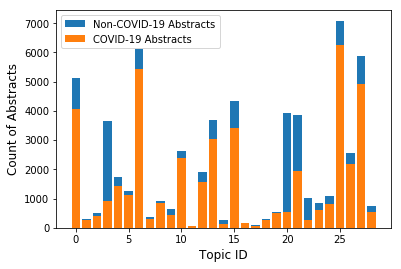

In [62]:
fig, ax = plt.subplots()
plt.bar(np.arange(0, max(metadata_dt_analysis['Dominant_Topic'])),
        np.bincount(metadata_dt_analysis['Dominant_Topic'], minlength=max(metadata_dt_analysis['Dominant_Topic']))[1:], 
        label='Non-COVID-19 Abstracts')
subset_COVID = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]
plt.bar(np.arange(0, max(subset_COVID['Dominant_Topic'])),
        np.bincount(subset_COVID['Dominant_Topic'], minlength=max(subset_COVID['Dominant_Topic']))[1:], 
        label='COVID-19 Abstracts')
plt.xlabel('Topic ID', size=12)
plt.ylabel('Count of Abstracts', size=12)
# plt.title('Distribution of Abstracts Across Topics', size=14)
# fig.savefig('Paper/Figures/6.png', dpi=dpi)
plt.legend()

## Key figure 1 in the paper 

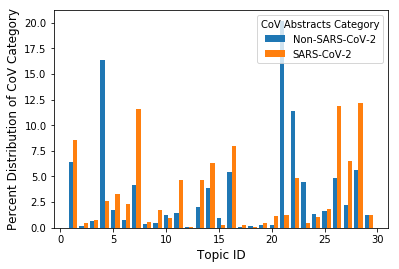

In [72]:
abstract_cnts = np.bincount(metadata_dt_analysis['Dominant_Topic'][metadata_dt_analysis['abstract_COVID'] == 0] ,
                    minlength=max(metadata_dt_analysis['Dominant_Topic'][metadata_dt_analysis['abstract_COVID'] == 0]))[1:]
abstract_cnts = abstract_cnts / sum(abstract_cnts) * 100

fig, ax = plt.subplots()
plt.bar(np.arange(0, max(metadata_dt_analysis['Dominant_Topic'])) + 1,
        abstract_cnts, 
        label='Non-SARS-CoV-2', width=0.4)

abstract_cnts = np.bincount(subset_COVID['Dominant_Topic'], minlength=max(subset_COVID['Dominant_Topic']))[1:]
abstract_cnts = abstract_cnts / sum(abstract_cnts) * 100
subset_COVID = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]
plt.bar(np.arange(0, max(subset_COVID['Dominant_Topic'])) + 1 + .4,
        abstract_cnts, 
        label='SARS-CoV-2', width=0.4)
plt.xlabel('Topic ID', size=12)
plt.ylabel('Percent Distribution of CoV Category', size=12)
# plt.title('Distribution of Abstracts Across Topics', size=14)
plt.legend(title='CoV Abstracts Category')
fig.savefig('/Users/lu_qxl/Desktop/5.png', dpi=dpi)
plt.show()

In [64]:
subset_COVID = metadata_dt_analysis[
    metadata_dt_analysis['abstract_COVID'] &
    (subset_COVID['converted_datetime'] > datetime.datetime(2020, 1, 1))]

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


Topic families

In [69]:
t_testing = [8,22,7,19,20]
t_treatment = [0,2,3,16,17,25]
t_response_to_mitigate_outbreaks = [1,26,27]
t_societal_impact_of_outbreaks = [5,6,9,12,18]
t_microbiology_general = [4,10,21] 
t_microbiology_Infection = [11,23,15]
t_outbreak_reporting = [24,28]
t_transmission_model = [13,14,29]

t_all = [t_testing, t_treatment, t_response_to_mitigate_outbreaks, t_societal_impact_of_outbreaks, 
         t_microbiology_general, t_microbiology_Infection, t_outbreak_reporting, t_transmission_model]
t_all_names = ['Clinical Issues: Clinical and Testing Diagnostics', 'Clinical Issues: Patient Care and Treatment', 
               'Outbreaks: Responses to Mitigate Them', 
               'Outbreaks: Societal Impact of Them', 'Basic Microbiology: General',
               'Basic Microbiology: Infection', 'General Outbreak Reporting', 'Modeling for Disease Transmission']


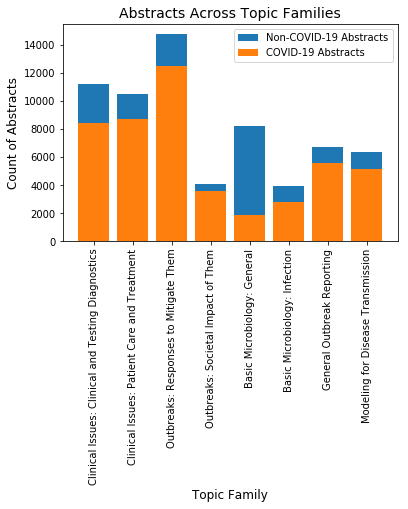

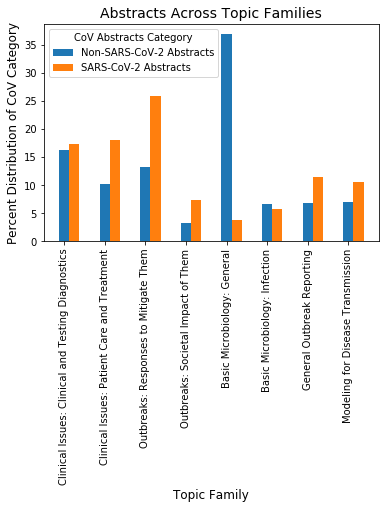

In [81]:
sums_all, sums_covid = [], []
for t, lst in enumerate(t_all):
    boolean = metadata_dt_analysis['Dominant_Topic'].isin(lst)
    sums_all.append(sum(boolean))
    boolean = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]['Dominant_Topic'].isin(lst)
    sums_covid.append(sum(boolean))
    
plt.bar(np.arange(0, len(t_all)),
        sums_all, 
        label='Non-COVID-19 Abstracts')
plt.bar(np.arange(0, len(t_all)),
        sums_covid, 
        label='COVID-19 Abstracts')
plt.xticks(np.arange(len(t_all)), t_all_names, rotation=90)
plt.ylabel('Count of Abstracts', size=12)
plt.xlabel('Topic Family', size=12)
plt.title('Abstracts Across Topic Families', size=14)
plt.legend()
plt.show()


## By percentage
sums_all, sums_covid = [], []
for t, lst in enumerate(t_all):
    boolean = metadata_dt_analysis['Dominant_Topic'].isin(lst)
    sums_all.append(sum(boolean))
    boolean = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']]['Dominant_Topic'].isin(lst)
    sums_covid.append(sum(boolean))
    
sums_all = np.array(sums_all)
sums_covid = np.array(sums_covid)
    
sums_all = sums_all - sums_covid # get non-COVID only
sums_covid = np.array(sums_covid) * 100 / sum(sums_covid)
sums_all = np.array(sums_all) * 100 / sum(sums_all)

    
plt.bar(np.arange(0, len(t_all)),
        sums_all, 
        label='Non-SARS-CoV-2 Abstracts', width=0.25)
plt.bar(np.arange(0, len(t_all)) + 0.25,
        sums_covid, 
        label='SARS-CoV-2 Abstracts', width=0.25)
plt.xticks(np.arange(len(t_all)), t_all_names, rotation=90)
plt.ylabel('Percent Distribution of CoV Category', size=12)
plt.xlabel('Topic Family', size=12)
plt.title('Abstracts Across Topic Families', size=14)
plt.legend(title='CoV Abstracts Category')
plt.show()

## Key figure 2 in the paper 

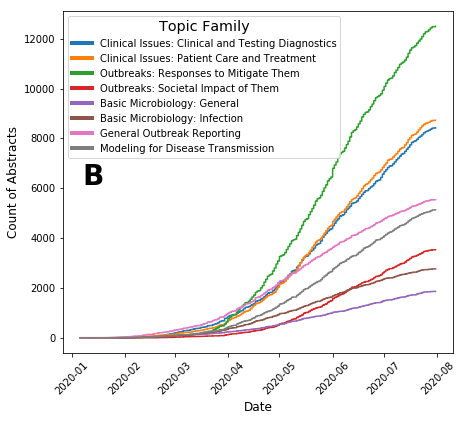

In [71]:
# drop abstracts at 2020 jan 1 due to datetime issues, then normalize later
subset_COVID2 = subset_COVID[subset_COVID['converted_datetime'] > datetime.datetime(2020,1,1)]
norm_factor = len(subset_COVID) / len(subset_COVID2)

sums_all, sums_covid = [], []
fig, ax = plt.subplots(figsize=(7, 7))

covid_normalizer_df = metadata_dt_analysis[metadata_dt_analysis['abstract_COVID']] # use this to normalize cumsums for abstracts with just 2020 as date
x = 0
for t, lst in enumerate(t_all):
    boolean = subset_COVID2['Dominant_Topic'].isin(lst)
    normalize_boolean = covid_normalizer_df['Dominant_Topic'].isin(lst)
    norm_factor = np.sum(normalize_boolean) / np.sum(boolean)
    sums_covid.append(sum(boolean) * norm_factor)
    x += sum(boolean) * norm_factor
    plt.plot(subset_COVID2['converted_datetime'], np.cumsum(boolean) * norm_factor, label = t_all_names[t])
plt.xticks(rotation=45)

leg = ax.legend(title='Topic Family')
plt.setp(leg.get_title(),fontsize='x-large')
# get the individual lines inside legend and set line width
for line in leg.get_lines():
    line.set_linewidth(4)
    
plt.ylabel('Count of Abstracts', size=12)
plt.xlabel('Date', size=12)
plt.text(0.05, 0.555, 'B', transform=ax.transAxes, fontsize=28, fontweight='bold', va='top')
# plt.title('Topic Families Over Time in COVID-19 Abstracts', size=14)
# plt.yscale('log')
plt.gcf().subplots_adjust(bottom=0.20)
plt.savefig('/Users/lu_qxl/Desktop/6b.png', dpi=dpi)

# COVID Distribution

In [50]:
topics_distribution = dominant_topic_30.groupby(['Dominant_Topic']).agg({'abstract_COVID': 'sum'})

# topic_COVID_presentage = topics_distribution.groupby(level=0).apply(lambda x:
                                                 #100 * x / float(x.count()))
topic_tot = dominant_topic_30.groupby(['Dominant_Topic']).agg({'abstract_COVID': 'count'})

In [51]:
covid_distribution = pd.merge(topics_distribution,topic_tot, on = "Dominant_Topic")

In [52]:
covid_distribution['COVID_Percentage'] = covid_distribution['abstract_COVID_x']/covid_distribution['abstract_COVID_y']

In [53]:
covid_distribution

,abstract_COVID_x,abstract_COVID_y,COVID_Percentage
Dominant_Topic,,,
0.0,150,458,0.327511
1.0,6,43,0.139535
2.0,56,160,0.350000
3.0,75,160,0.468750
...,...,...,...
26.0,407,815,0.499387
27.0,35,640,0.054688
28.0,24,254,0.094488
29.0,5,55,0.090909


In [54]:
covid_distribution.rename(columns={"abstract_COVID_x": "abstract_COVID", "abstract_COVID_y": "total"})

,abstract_COVID,total,COVID_Percentage
Dominant_Topic,,,
0.0,150,458,0.327511
1.0,6,43,0.139535
2.0,56,160,0.350000
3.0,75,160,0.468750
...,...,...,...
26.0,407,815,0.499387
27.0,35,640,0.054688
28.0,24,254,0.094488
29.0,5,55,0.090909


In [55]:
covid_distribution.to_csv("big_data/covid_distribution_30.csv")